In [76]:
#import the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer ## HAndle Missing Values
from sklearn.preprocessing import StandardScaler ## Feature Scaling
from sklearn.preprocessing import LabelEncoder ## categorical to numerical
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import pickle




>You are a df scientist working for a healthcare company, and you have been tasked with creating a decision tree to help identify patients with diabetes based on a set of clinical variables. You have been given a dfset (diabetes.csv) with the following variables:
1. Pregnancies: Number of times pregnant (integer)
2. Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test (integer)
3. BloodPressure: Diastolic blood pressure (mm Hg) (integer)
4. SkinThickness: Triceps skin fold thickness (mm) (integer)
5. Insulin: 2-Hour serum insulin (mu Ulml) (integer)
6. BMI: Body mass index (weight in kg/(height in m)A2) (float)
7. DiabetesPedigreeFunction: Diabetes pedigree function (a function which scores likelihood of diabetes
based on family history) (float)
8. Age: Age in years (integer)
9. Outcome: Class variable (O if non-diabetic, 1 if diabetic) (integer)
>Here's the dfset link: https:/Idrive.google.com/fiIe/d/1Q4J8KS1wm4— _ YTuc389enPh60-eTNcx2/view?usp=sharing

>Your goal is to create a decision tree to predict whether a patient has diabetes based on the other variables. Here are the steps you can follow:

>Q1. Import the dfset and examine the variables. Use descriptive statistics and visualizations to understand the distribution and relationships between the variables.

In [79]:
df = pd.read_csv(r"C:\Users\milan\Documents\Data Science\skills\Notes\Pandas_\New Assq\diabetes.csv")

#### Show Top 5 Records

In [80]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [81]:
df.shape

(768, 9)

<AxesSubplot: >

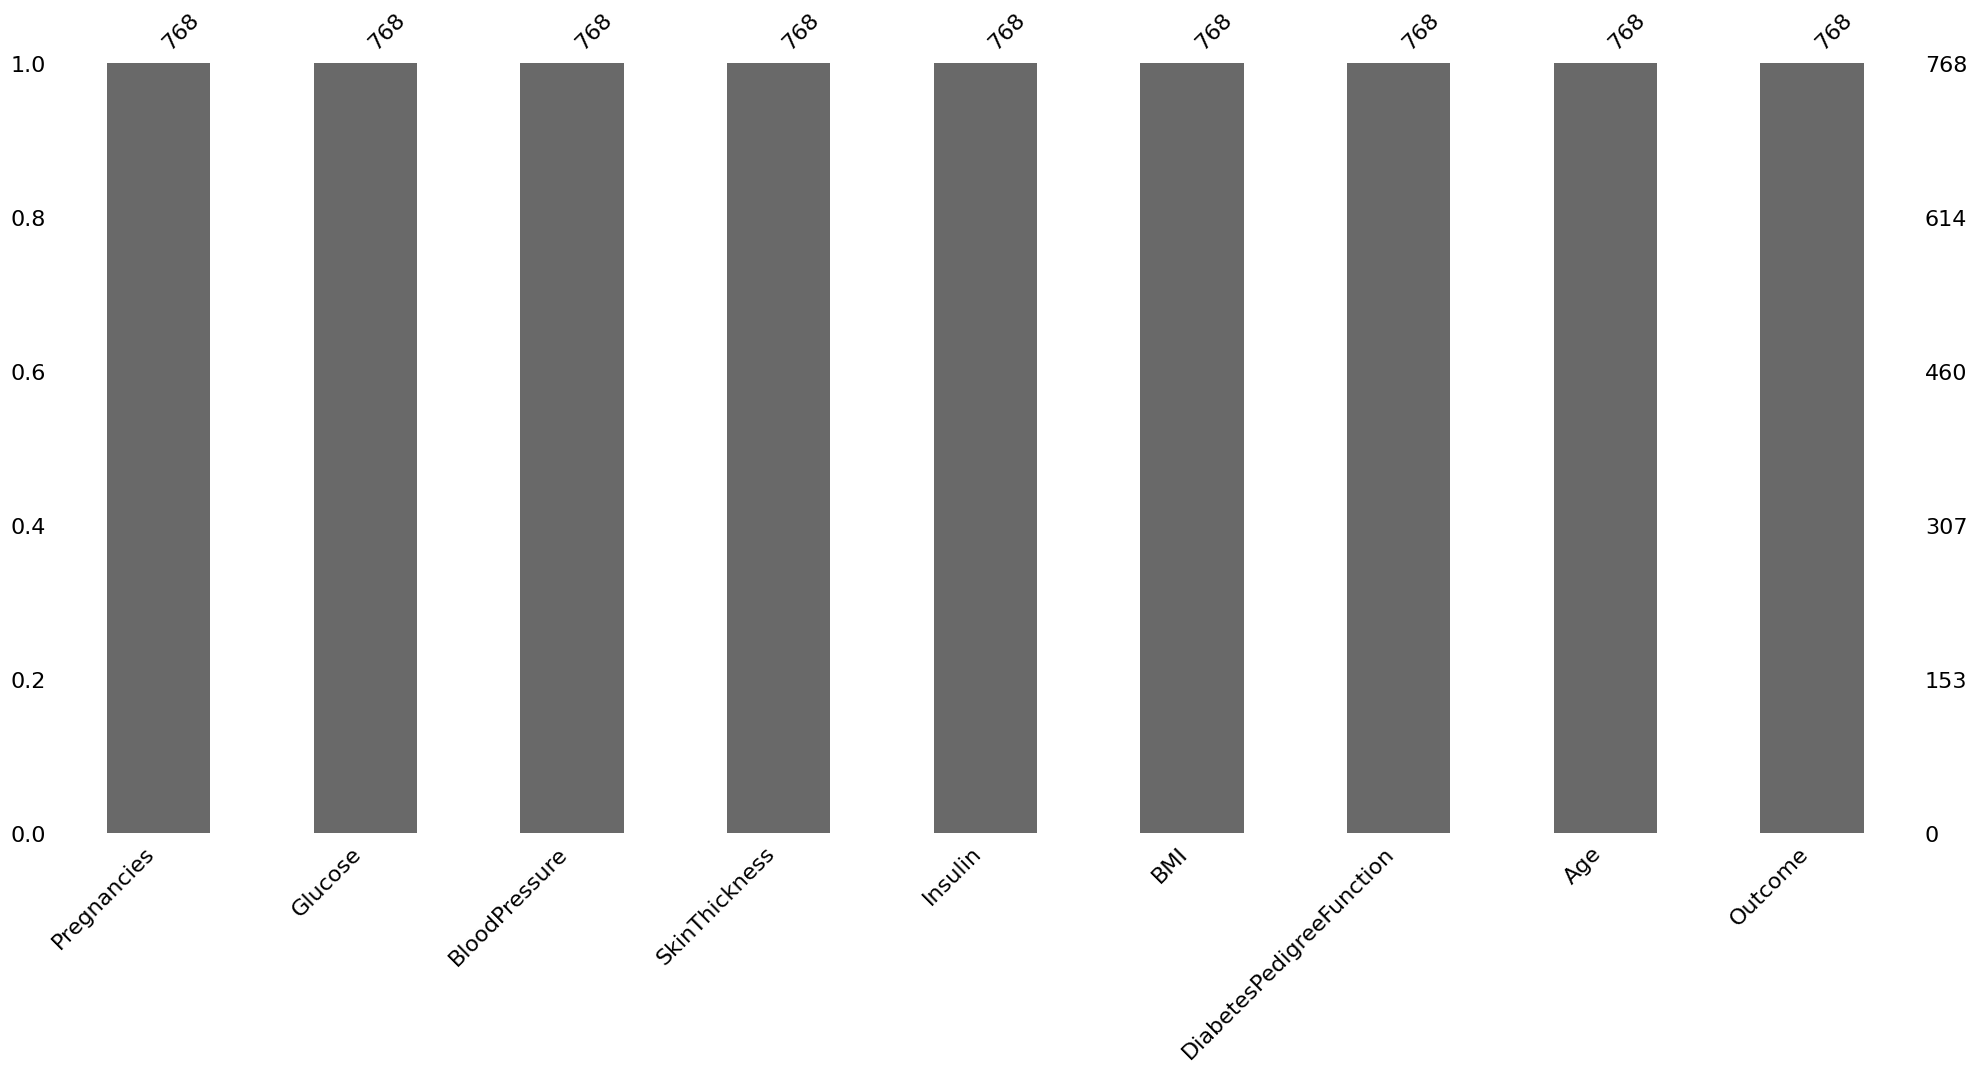

In [82]:
#missing values
msno.bar(df)

In [83]:
# duplicated value
df.duplicated().sum()

0

### We have no duplicated values in the dfset.

In [84]:
# check df type
df.info(verbose = 'TRUE')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## We have all numeric colums in our dfset.

In [85]:
# Checking the numbers of unique values for each columns
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

# Insights:


- The Pregnancies              column has   17 unique values.
- The Glucose                  column has  136 unique values.
- The BloodPressure            column has   47 unique values.
- The SkinThickness            column has   51 unique values.
- The Insulin                  column has  186 unique values.
- The BMI                      column has  248 unique values.
- The DiabetesPedigreeFunction column has  517 unique values.
- The Age                      column has   52 unique values.
- The Outcome                  column has    2 unique values.

In [86]:
# Check the statistics of the dfset

styled_table = df.describe().T.style.bar(subset=['mean'], color='#205ff2') \
               .background_gradient(subset=['std'], cmap='Reds') \
               .background_gradient(subset=['50%'], cmap='coolwarm')

styled_table


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.000000,120.894531,31.972618,0.000000,99.000000,117.000000,140.250000,199.000000
BloodPressure,768.000000,69.105469,19.355807,0.000000,62.000000,72.000000,80.000000,122.000000
SkinThickness,768.000000,20.536458,15.952218,0.000000,0.000000,23.000000,32.000000,99.000000
Insulin,768.000000,79.799479,115.244002,0.000000,0.000000,30.500000,127.250000,846.000000
BMI,768.000000,31.992578,7.884160,0.000000,27.300000,32.000000,36.600000,67.100000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


#### We can see there few df for columns Glucose , Insulin, skin thickenss, BMI and Blood Pressure which have value as 0. That's not possible,right? you can do a quick search to see that one cannot have 0 values for these.
#### Let's deal with that. we can either remove such df or simply replace it with their respective mean values.

In [87]:
#here few misconception is there lke BMI can not be zero, BP can't be zero, glucose, insuline can't be zero so lets try to fix it
# now replacing zero values with the mean of the column
df['BMI'] = df['BMI'].replace(0,df['BMI'].mean())
df['BloodPressure'] = df['BloodPressure'].replace(0,df['BloodPressure'].mean())
df['Glucose'] = df['Glucose'].replace(0,df['Glucose'].mean())
df['Insulin'] = df['Insulin'].replace(0,df['Insulin'].mean())
df['SkinThickness'] = df['SkinThickness'].replace(0,df['SkinThickness'].mean())



In [88]:
# Check the statistics of the dfset

styled_table = df.describe().T.style.bar(subset=['mean'], color='#205ff2') \
               .background_gradient(subset=['std'], cmap='Reds') \
               .background_gradient(subset=['50%'], cmap='coolwarm')

styled_table


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000000,3.845052,3.369578,0.000000,1.000000,3.000000,6.000000,17.000000
Glucose,768.000000,121.681605,30.436016,44.000000,99.750000,117.000000,140.250000,199.000000
BloodPressure,768.000000,72.254807,12.115932,24.000000,64.000000,72.000000,80.000000,122.000000
SkinThickness,768.000000,26.606479,9.631241,7.000000,20.536458,23.000000,32.000000,99.000000
Insulin,768.000000,118.660163,93.080358,14.000000,79.799479,79.799479,127.250000,846.000000
BMI,768.000000,32.450805,6.875374,18.200000,27.500000,32.000000,36.600000,67.100000
DiabetesPedigreeFunction,768.000000,0.471876,0.331329,0.078000,0.243750,0.372500,0.626250,2.420000
Age,768.000000,33.240885,11.760232,21.000000,24.000000,29.000000,41.000000,81.000000
Outcome,768.000000,0.348958,0.476951,0.000000,0.000000,0.000000,1.000000,1.000000


<AxesSubplot: >

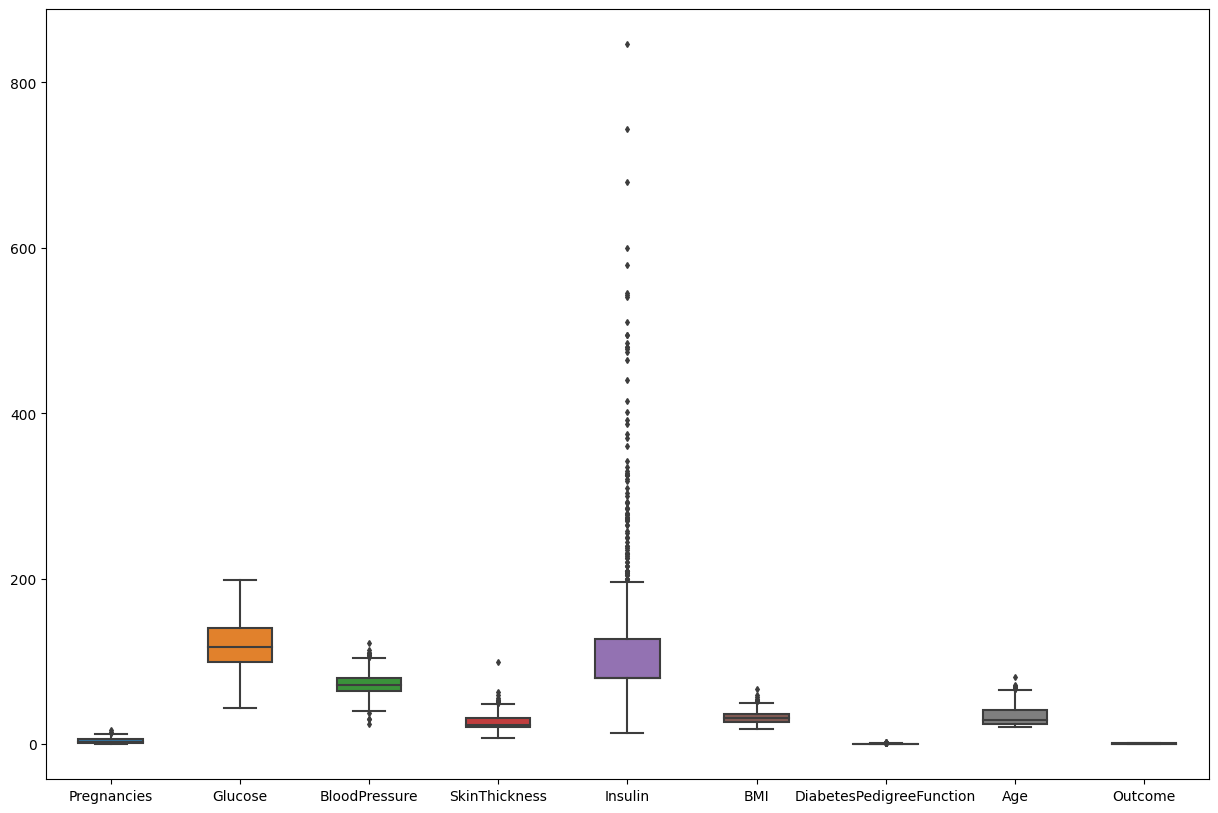

In [89]:
#now we have dealt with the 0 values and data looks better. But, there still are outliers present in some columns.lets visualize it
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=df, width= 0.5,ax=ax,  fliersize=3)

In [90]:
# difine numerical and categorical features
num_features = [features for features in df.columns if df[features].dtype !='O']
cat_features = [features for features in df.columns if df[features].dtype =='O']

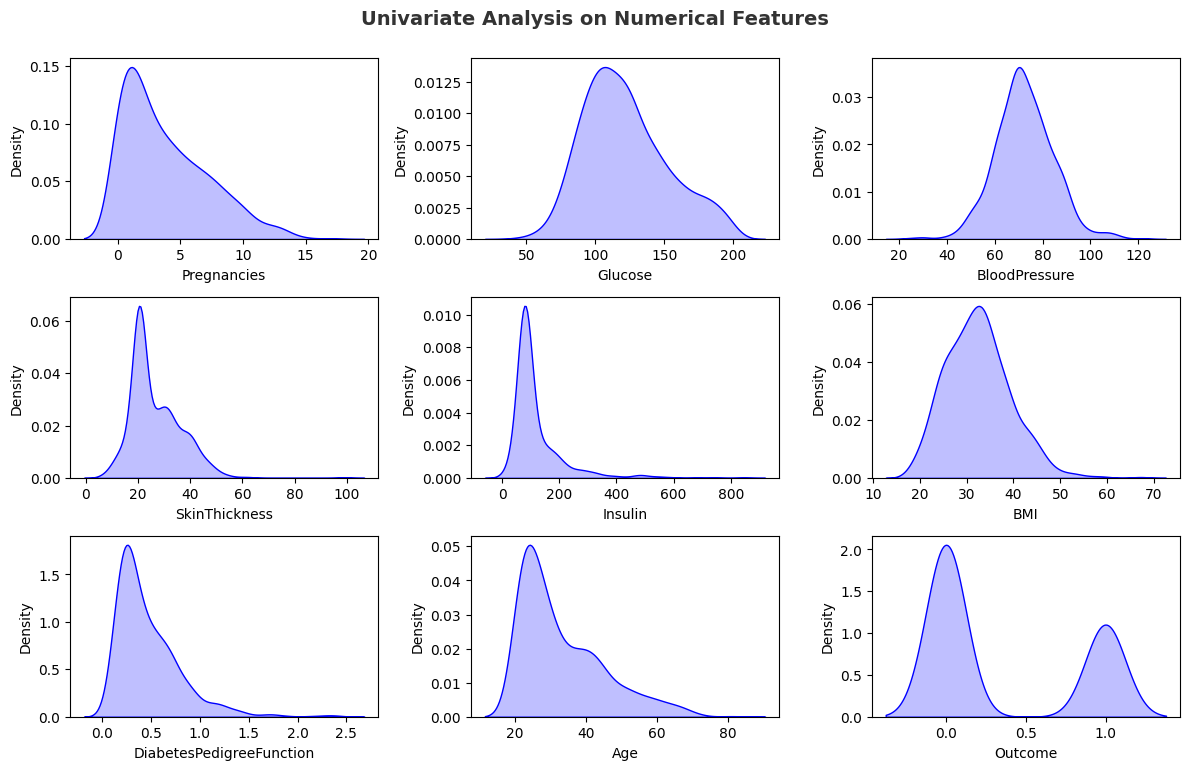

In [91]:
# Univariate Analysis on Numerical Features

#Set the figure size and title # alpha will control the transparency of the plot & y=1 the subtitple will be at the top of the figure & 0 will be at bottom
plt.figure(figsize = (12,12))
plt.suptitle('Univariate Analysis on Numerical Features', fontsize = 14, fontweight = "bold", alpha = 0.8, y = 1)

# loop through each numerical features and plot its density plot 
for i in range(0,len(num_features)): #0 represents the start of index since python starts with 0 index
    plt.subplot(5,3, i+1) #create a subplot for each feature
    sns.kdeplot(x = df[num_features [i]], shade = True, color = 'b') # kde is a density plot and shade will add color below the curve
    plt.xlabel(num_features[i]) # Add labels to x-axis
    plt.tight_layout()
    
# Save the plot
#plt.savefig('./images/univariate_analysis.png') 

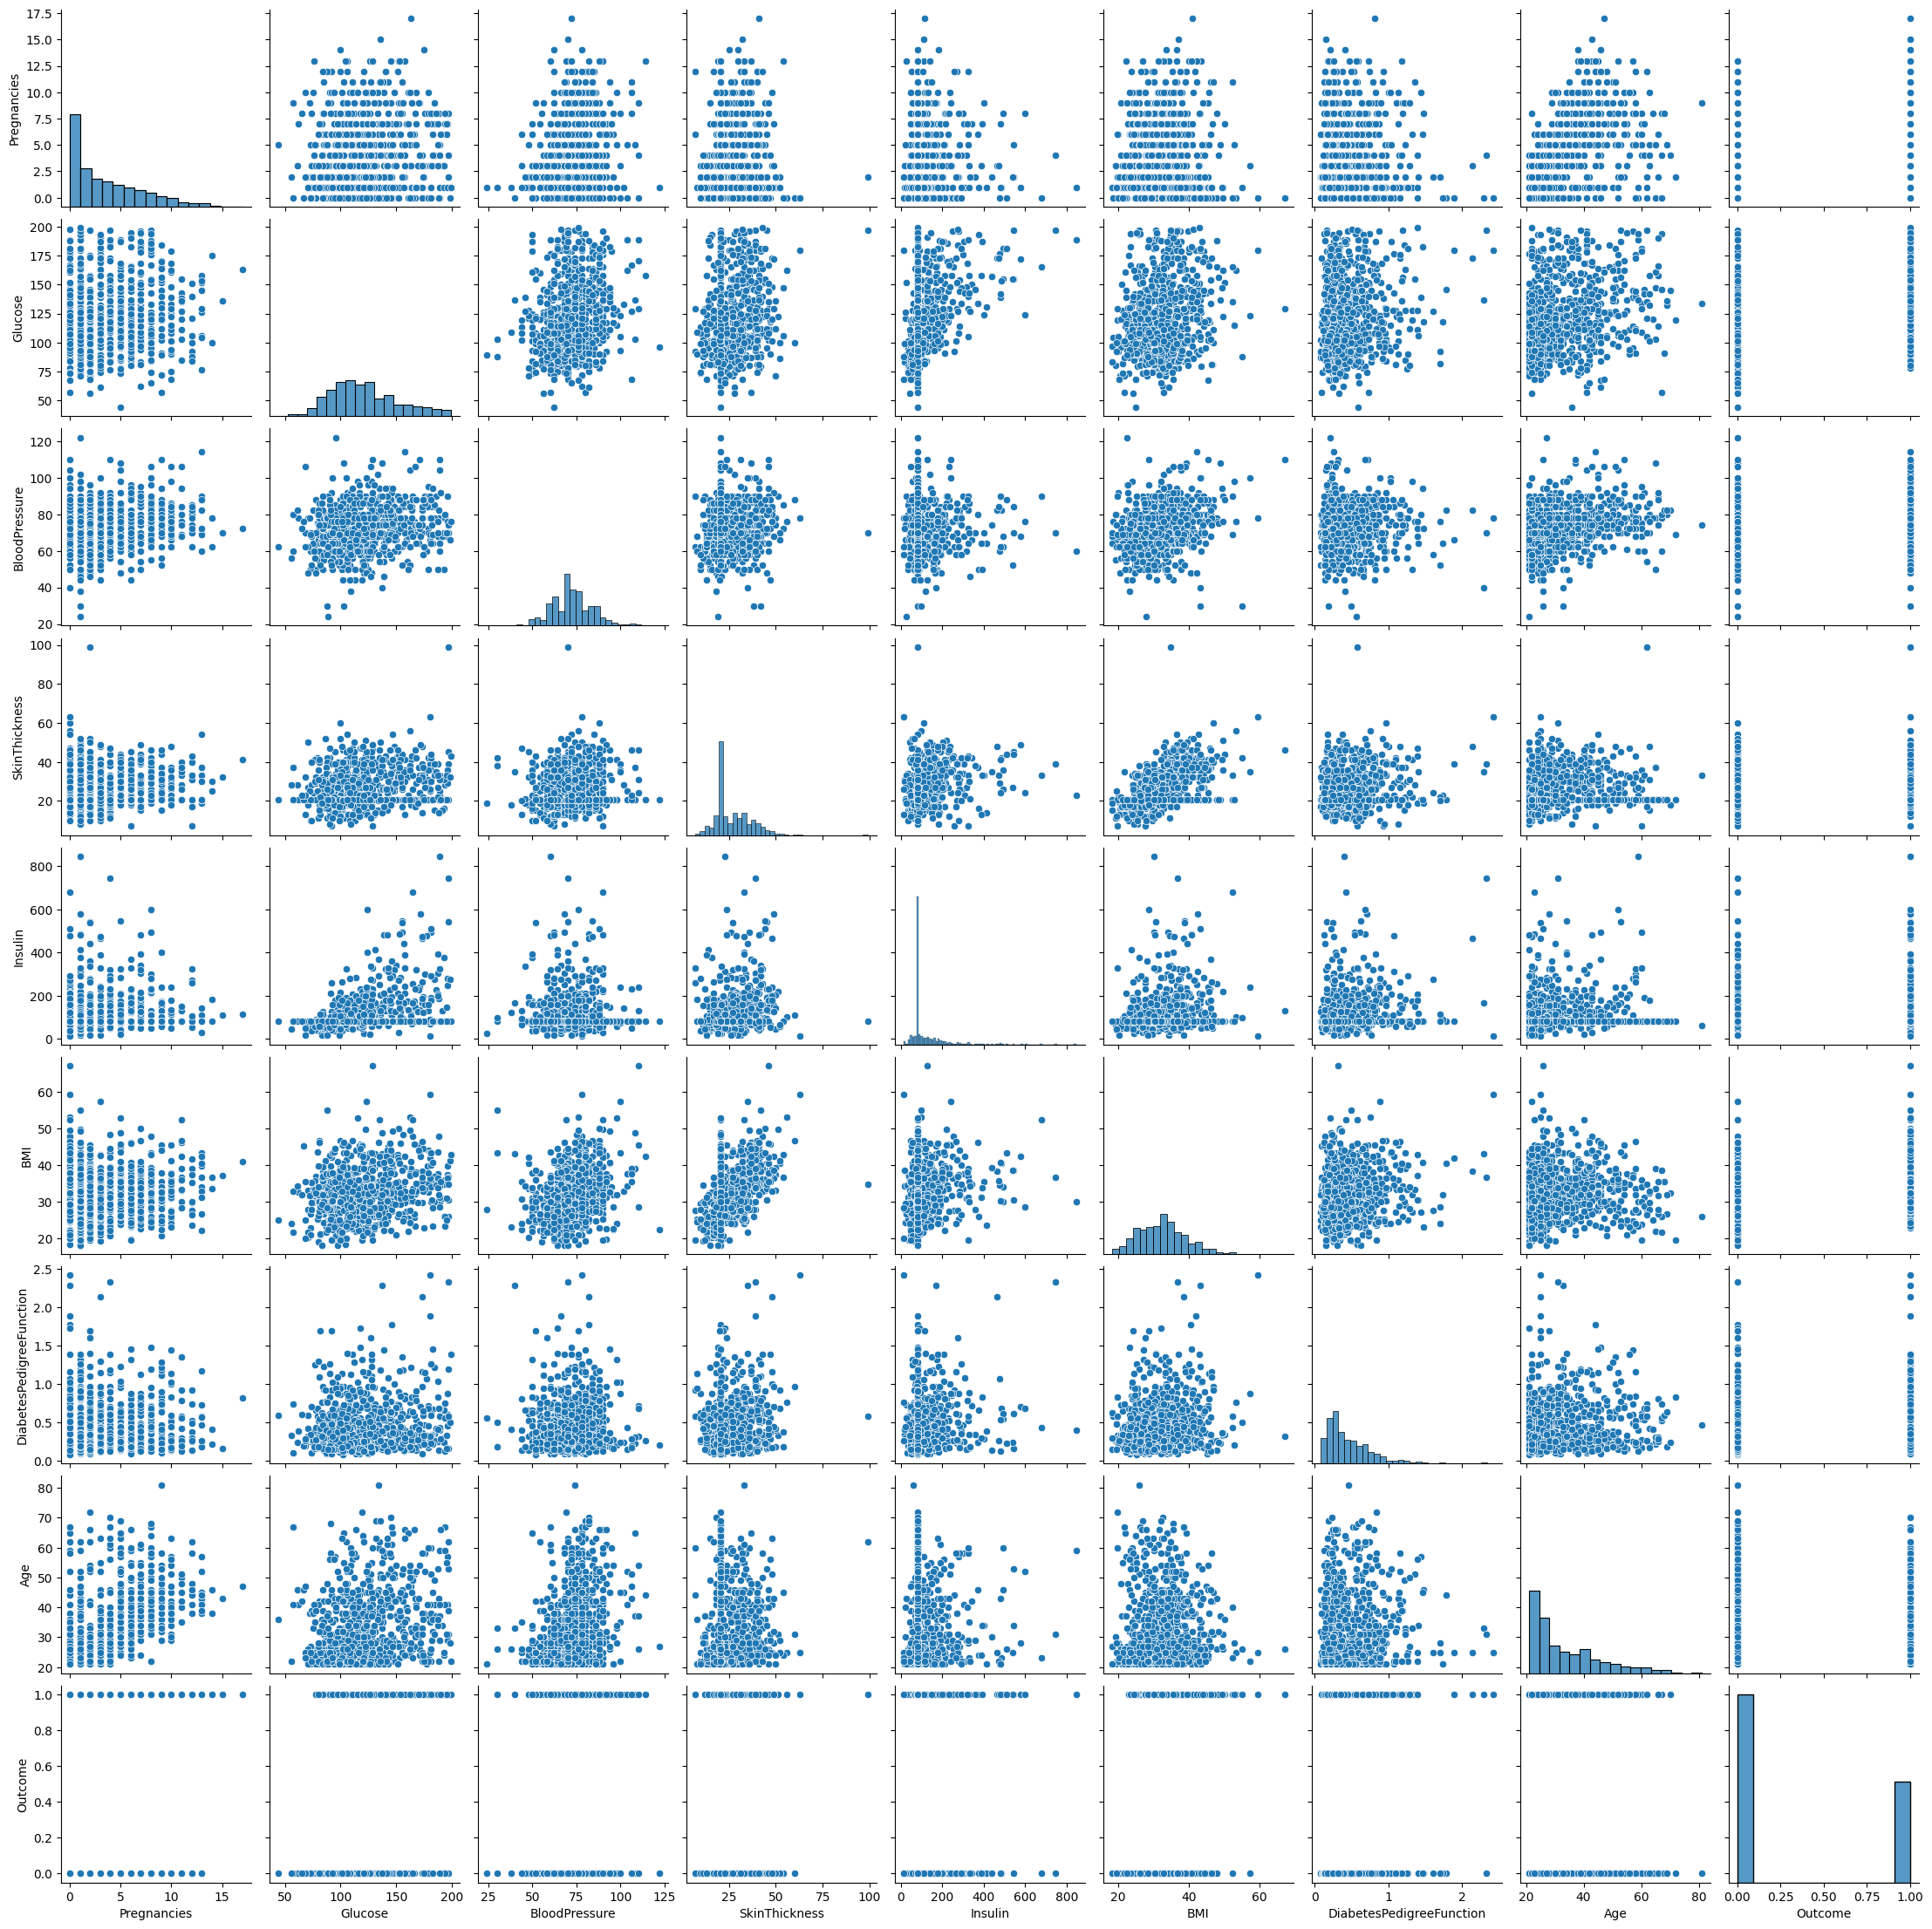

In [92]:
sns.pairplot(df)

# Q2. Preprocess the data by cleaning missing values, removing outliers, and transforming categorical variables into dummy variables if necessary.

# Q3. Split the dataset into a training set and a test set. Use a random seed to ensure reproducibility.

#### we don't have missing values in the dataset.

In [114]:
def replace_outliers_nrm(normalized_df,columns):
    for col in columns:
  
        
        Q1=normalized_df[col].quantile(0.25)
        Q3=normalized_df[col].quantile(0.75)

        IQR=Q3-Q1
        
        lower_bound=Q1 - 1.5*IQR
        upper_bound=Q3 + 1.5*IQR
        
        #replace min and max value with lower_bound and upper_bound
        
        normalized_df.loc[(normalized_df[col]>upper_bound),col] = upper_bound
        normalized_df.loc[(normalized_df[col]<lower_bound),col] = lower_bound
        
    return normalized_df

In [115]:
# Call the function to replace the outliers

cols_with_outliers=['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

normalized_df=replace_outliers_nrm(df,cols_with_outliers)

<AxesSubplot: >

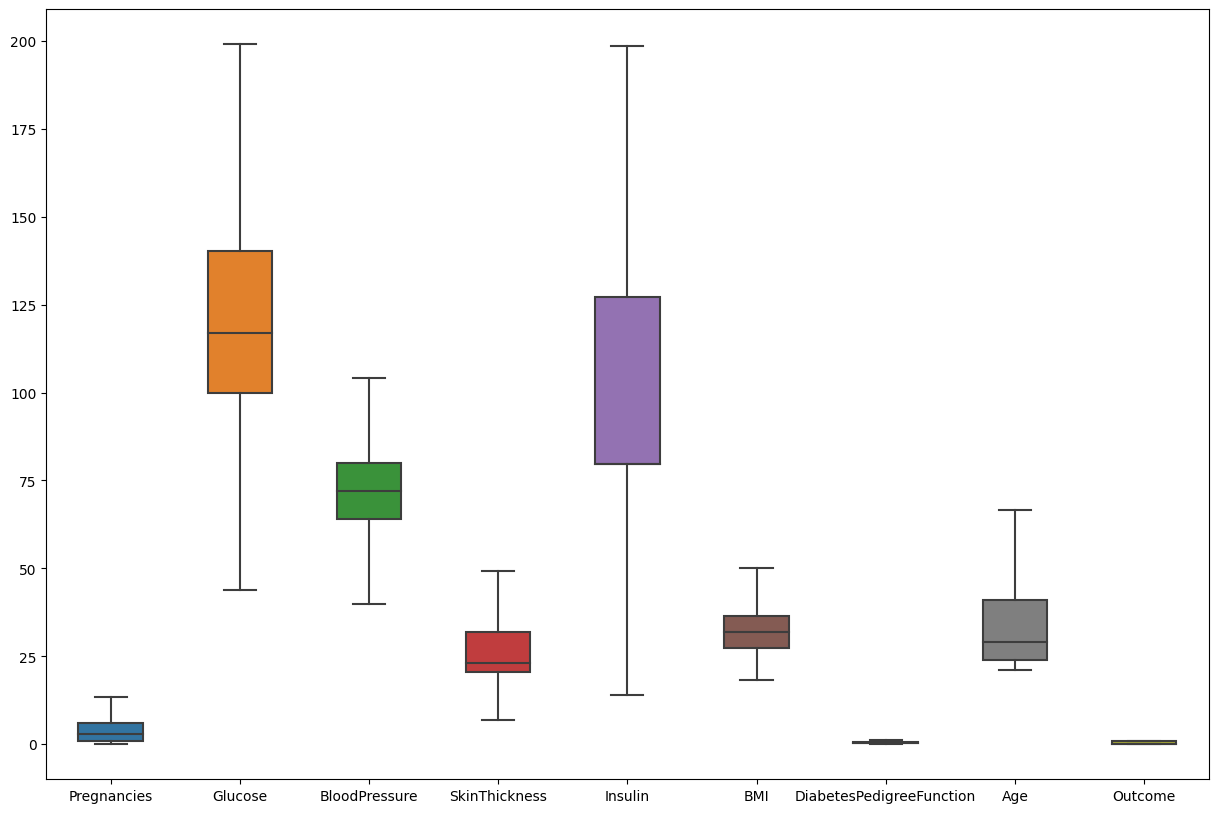

In [116]:
#now we have dealt with the 0 values and data looks better. But, there still are outliers present in some columns.lets visualize it
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=normalized_df, width= 0.5,ax=ax,  fliersize=3)

In [117]:
#segregate the dependent and independent variable
X = normalized_df.drop(columns = ['Outcome'])
y = normalized_df['Outcome']

In [118]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape

((576, 8), (192, 8))

In [119]:
import pickle
##standard Scaling- Standardization
def scaler_standard(X_train, X_test):
    #scaling the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [120]:
X_train_scaled, X_test_scaled = scaler_standard(X_train, X_test)

# Q4. Use a decision tree algorithm, such as ID3 or C4.5, to train a decision tree model on the training set. Use cross-validation to optimize the hyperparameters and avoid overfitting.

In [121]:
# Define the hyperparameters you want to tune
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt', 'log2']}

In [122]:
classifier=DecisionTreeClassifier()

In [123]:
clf=GridSearchCV(classifier,param_grid=parameters,cv=5,scoring='accuracy',verbose=3, n_jobs=-1)

In [124]:
%time
clf.fit(X_train_scaled,y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=3)

In [125]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'splitter': 'random'}

In [126]:
classifier=DecisionTreeClassifier(criterion        = 'entropy',
                                  max_depth        = 50,
                                  max_features     = 'log2',
                                  min_samples_leaf = 4,
                                  min_samples_split= 2,
                                  splitter         = 'best')

In [127]:
classifier.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=50, max_features='log2',
                       min_samples_leaf=4)

In [135]:
## Decision Tree prediction
y_pred = classifier.predict(X_test_scaled)

# Q5. Evaluate the performance of the decision tree model on the test set using metrics such as accuracy, precision, recall, and Fl score. Use confusion matrices and ROC curves to visualize the results.

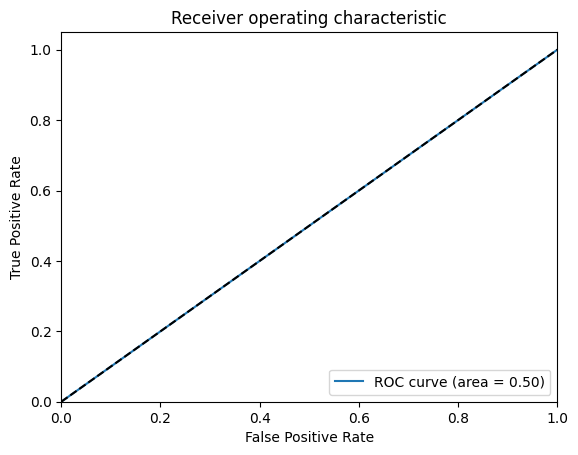

In [136]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [137]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)
print("Confusion matrix:")
print(cm)

Accuracy: 0.640625
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Confusion matrix:
[[123   0]
 [ 69   0]]


# Q6. Interpret the decision tree by examining the splits, branches, and leaves. Identify the most important variables and their thresholds. Use domain knowledge and common sense to explain the patterns and trends.

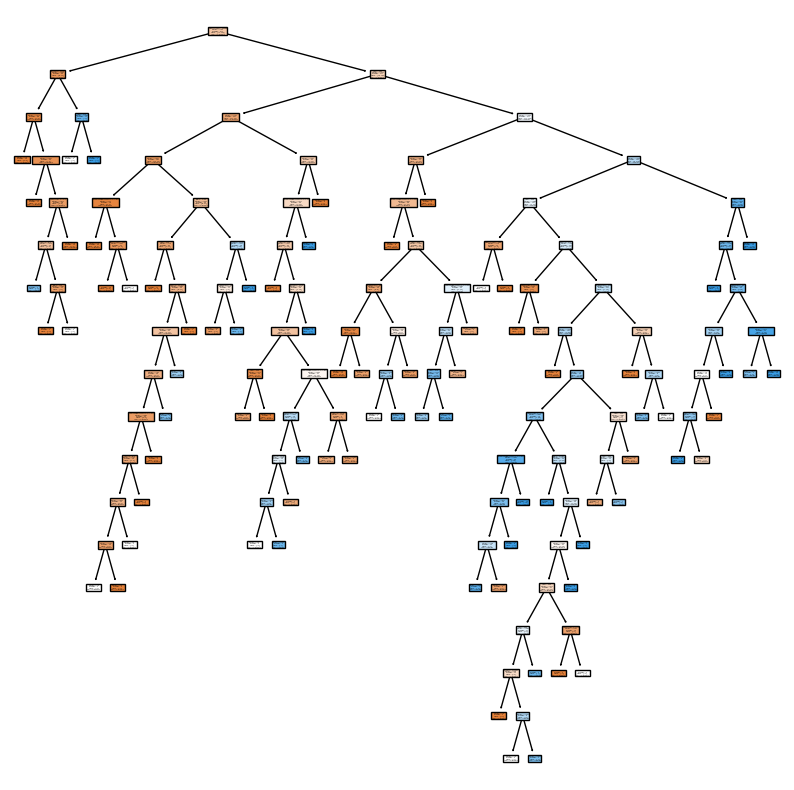

1. Age (0.206087)
2. Glucose (0.204653)
3. SkinThickness (0.114600)
4. Insulin (0.111801)
5. DiabetesPedigreeFunction (0.103614)
6. BloodPressure (0.094014)
7. BMI (0.090786)
8. Pregnancies (0.074444)


In [132]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt



# visualize the decision tree
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(classifier, filled=True, ax=ax, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'])
plt.show()

# find important features
importance = classifier.feature_importances_
indices = np.argsort(importance)[::-1]
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importance[indices[f]]))


>Great, the results indicate that the most important feature for predicting diabetes in the dataset is Age, followed closely by Glucose. The SkinThickness and Insulin features also have relatively high importance scores, while the BMI and Pregnancies features have lower scores. The BloodPressure and DiabetesPedigreeFunction features have the lowest importance scores.

>These results suggest that age and glucose levels are the most important predictors of diabetes in the dataset, which is consistent with the domain knowledge and common sense that we discussed earlier. Additionally, the importance scores for the SkinThickness and Insulin features suggest that these variables may also be useful for predicting diabetes, although they are not as important as age and glucose levels.

>It's worth noting that the importance scores are relative to each other and do not necessarily represent the actual impact of each feature on the outcome. Therefore, it's important to consider the actual values of the features and their interactions with each other when interpreting the results.







# Q7. Validate the decision tree model by applying it to new data or testing its robustness to changes in the dataset or the environment. Use sensitivity analysis and scenario testing to explore the uncertainty and risks.

>To validate the decision tree model, we can apply it to new data that was not used in the training process. This can be done by splitting the original dataset into a training set and a testing set, where the training set is used to train the model and the testing set is used to evaluate its performance on new data.

In [139]:
# evaluate the performance of the model on the testing set
y_pred = classifier.predict(X_test_scaled)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("Precision: {}".format(precision_score(y_test, y_pred)))
print("Recall: {}".format(recall_score(y_test, y_pred)))
print("F1 score: {}".format(f1_score(y_test, y_pred)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))


Accuracy: 0.640625
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Confusion matrix:
[[123   0]
 [ 69   0]]


>Sensitivity analysis and scenario testing can be used to explore the uncertainty and risks associated with the decision tree model. For example, we can test the robustness of the model to changes in the dataset or the environment by varying the parameters of the model or introducing new data points that are different from the ones used in the training and testing sets. We can also perform sensitivity analysis by varying the input features and observing the output of the model to see how sensitive it is to changes in the input values.

>Overall, validating the decision tree model using new data and sensitivity analysis can help us understand its strengths and weaknesses and make more informed decisions based on the predictions it produces.